# Import libraries

In [0]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**List the devices available to tensorflow**

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 475625563311316207, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11297803469
 locality {
   bus_id: 1
 }
 incarnation: 10019618925649727733
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
!pip install --upgrade gensim
from gensim.models.word2vec import Word2VecKeyedVectors

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: numpy>=1.11.3 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: scipy>=0.18.1 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: six>=1.5.0 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: smart-open>=1.2.1 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: bz2file in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: boto>=2.32 in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: boto3 in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: chardet<3.1.0,>=

**Make the result reproducible by setting the seed of numpy and tensorflow**

In [4]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


# Load the cleaned data

**Authentication via google auth**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Upload a file from google cloud where file ids are stored as a json**

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

file_id_data= json.loads(uploaded['file_id.json'])

Saving file_id.json to file_id (3).json
User uploaded file "file_id.json" with length 489 bytes


**Download files to the kernel**

In [0]:
downloaded1 = drive.CreateFile({'id':file_id_data["modified_train_file_id"]}) 
downloaded1.GetContentFile('modified_train_data.csv')  
downloaded2 = drive.CreateFile({'id':file_id_data["modified_test_file_id"]}) 
downloaded2.GetContentFile('modified_test_data.csv')
downloaded3 = drive.CreateFile({'id':file_id_data["word2vec_model"]}) 
downloaded3.GetContentFile('word2vec_model')  
downloaded4 = drive.CreateFile({'id':file_id_data["data"]}) 
downloaded4.GetContentFile('data.json')

**Load train and test data to notebook**

In [0]:
#3. Read file as panda dataframe
data = pd.read_csv('modified_train_data.csv') 
test_data = pd.read_csv('modified_test_data.csv')

**Remove the csv files from kernel**

In [0]:
os.remove("modified_train_data.csv")
os.remove("modified_test_data.csv")

**Extract size from the json file**

In [0]:
metadata= json.loads(open("data.json").read())
size = metadata['size']

**Extract the size of Word2Vec model**

In [0]:
fname = "word2vec_model"
model = Word2VecKeyedVectors.load_word2vec_format(fname)

In [0]:
os.remove("word2vec_model")

# Inspect the distribution of #words in the sentences

**Distribution of #words in train data**

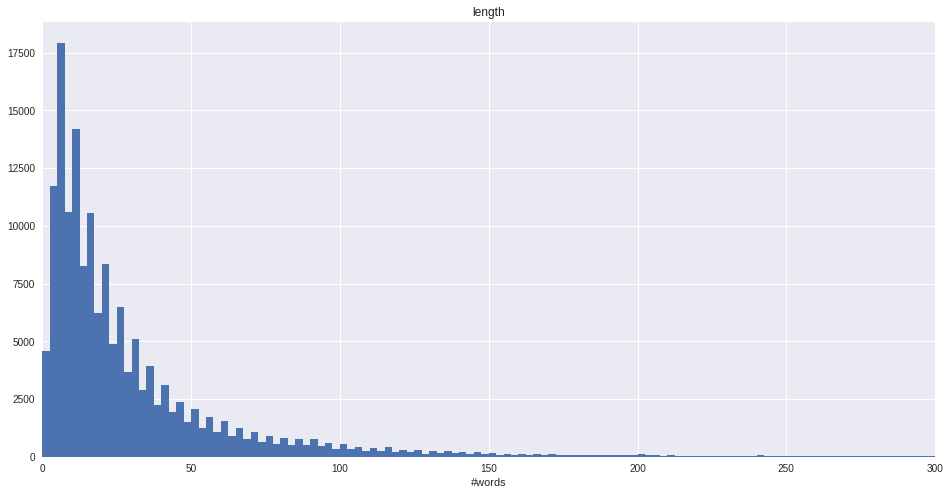

In [13]:
data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in test data**

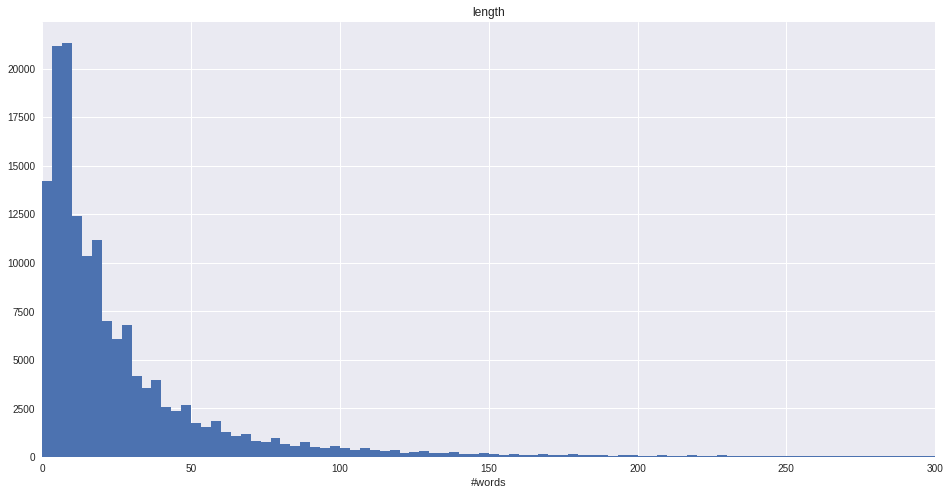

In [14]:
test_data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in all data**

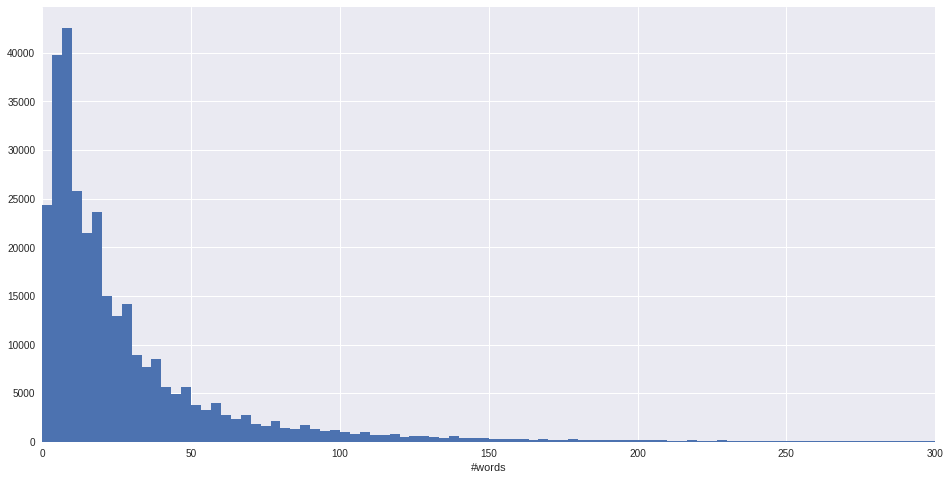

In [15]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=500, figsize=(16,8))
plt.xlim(0,300)
plt.xlabel("#words")
plt.show()
del(all_length)

# Train validation split

**Extract the train, validation, and test data in numpy arrays**

In [0]:
comments = data["comment_text"].as_matrix()
sentiments = data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].as_matrix()
seq_length = data['length'].as_matrix()

# randomly generate train and validation indices
train_indices = np.random.choice(len(seq_length), round(len(seq_length)*0.96), replace=False)
validation_indices = np.array(list(set(range(len(seq_length))) - set(train_indices)))

comments_train = comments[train_indices]
comments_validation = comments[validation_indices]
comments_test = test_data["comment_text"].as_matrix()

seq_length_train = seq_length[train_indices]
seq_length_validation = seq_length[validation_indices]
seq_length_test = test_data['length'].as_matrix()

sentiments_train = sentiments[train_indices]
sentiments_validation = sentiments[validation_indices]

test_id = test_data['id'].as_matrix()

In [17]:
print("shape of comments_train:",comments_train.shape)
print("shape of comments_validation:",comments_validation.shape)
print("shape of comments_test:",comments_test.shape)
print("shape of seq_length_train:",seq_length_train.shape)
print("shape of seq_length_validation:",seq_length_validation.shape)
print("shape of seq_length_test:",seq_length_test.shape)
print("shape of sentiments_train:",sentiments_train.shape)
print("shape of sentiments_test:",sentiments_validation.shape)
print("shape of test_id:",test_id.shape)

shape of comments_train: (153188,)
shape of comments_validation: (6383,)
shape of comments_test: (153164,)
shape of seq_length_train: (153188,)
shape of seq_length_validation: (6383,)
shape of seq_length_test: (153164,)
shape of sentiments_train: (153188, 6)
shape of sentiments_test: (6383, 6)
shape of test_id: (153164,)


In [0]:
del(train_indices, validation_indices, data, test_data, comments, sentiments, seq_length)

# Create Recurrent Neural Network (LSTM cell)

**A function to generate fixed length sequence**

In [0]:
def sequence_generator(comments, max_length, size):
    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**Parameters of sequence data**

In [0]:
max_length = n_steps = 300 
size = n_inputs = size
n_outputs = 6

**Function to generate batch data**

In [0]:
def generate_train_batch(indices, comments, seq_length, sentiments, max_length, size):
    
    comments_batch = comments[indices]
    seq_length_batch = seq_length[indices]
    sentiments_batch = sentiments[indices]
    
    sequences_batch = sequence_generator(comments_batch, max_length, size)
    
    return sequences_batch, seq_length_batch, sentiments_batch

**Placeholders**

In [0]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
labels = tf.placeholder(tf.float32, [None, n_outputs])
length = tf.placeholder(tf.int32, [None])
keep_prob = tf.placeholder(tf.float32)

## Creat RNN layer

**Create a multilayered lstm network**

In [0]:
n_layers = 2
n_neurons = 256

In [0]:
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
lstm_cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
                    for cell in lstm_cells]
cells_across_gpu = [tf.contrib.rnn.DeviceWrapper("/device:GPU:0", cell) for cell in lstm_cells_drop]

multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

**Extract the short term output of the last lstm cell**

In [25]:
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32, sequence_length=length)
top_layer_h_state = states[-1][1]
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 256) dtype=float32>

## Create fully connected layers

**Functions to create weights and biases**

In [0]:
def create_weights(shape):
    '''a function to create weight tensor'''
    with tf.device("/device:CPU:0"):
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    return W

def create_biases(size):
    '''a function to create bias tensor'''
    with tf.device("/device:CPU:0"):
        b = tf.Variable(tf.constant(0.05, shape=[size]))
    return b

**Function to create fully connected layer**

In [0]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=False,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    with tf.device("/device:GPU:0"):
      # matrix multiplication between input and weight matrix
      layer = tf.matmul(input, weights)

      # add the bias to the convolutional layer
      layer += biases

      # add relu activation if wanted
      if use_relu:
          layer = tf.nn.relu(layer)

      # if dropout is wanted add dropout
      if dropout:        
          layer = tf.nn.dropout(layer, keep_prob)

    # return layer
    return layer

**Create fully connected layer**

In [0]:
fc_layer_size1 = 36
# fc_layer_size2 = 64

In [29]:
layer_fc1 = create_fc_layer(input=top_layer_h_state,
                            num_inputs=top_layer_h_state.get_shape()[1].value,
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout =True,
                            keep_prob = keep_prob)
layer_fc1

<tf.Tensor 'dropout/mul:0' shape=(?, 36) dtype=float32>

In [0]:
# layer_fc2 = create_fc_layer(input=layer_fc1,
#                             num_inputs=fc_layer_size1,
#                             num_outputs=fc_layer_size2,
#                             use_relu=True,
#                             dropout =True,
#                             keep_prob = keep_prob)
# layer_fc2

**Create output layer**

In [31]:
output = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=n_outputs,
                            use_relu=False,
                            dropout =False)
output

<tf.Tensor 'add_1:0' shape=(?, 6) dtype=float32>

**Sigmoid of the output**

In [32]:
with tf.device("/device:GPU:0"):
    logits = tf.nn.sigmoid(output)
logits

<tf.Tensor 'Sigmoid:0' shape=(?, 6) dtype=float32>

## Create optimization operation

**Loss operation**

In [0]:
with tf.device("/device:GPU:0"):
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=output)

**ROC AUC calculation operations**

In [0]:
roc = tf.metrics.auc(labels=labels, predictions=logits)

**Train step**

In [0]:
# learning rate of optimizer
learning_rate = (1e-2)*.7
with tf.device("/device:GPU:0"):
  # train step
  train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Train the model

In [0]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []
valid_roc = []

# batch size
batch_size = 200
# max iteration
max_iter = 5000

**Train model for few hours and save the best model along the way**

In [37]:
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_accuracy = 0
best_roc = -10
best_iteration = None

iteration = 0

train_hours = 4.5

# feed dictionary for validation
feed_dict_validation =  {X:sequence_generator(comments_validation, max_length, size),
                        labels:sentiments_validation,
                        length:seq_length_validation,
                        keep_prob: 1.0}

t1 = time.time()

# create a graph session and optimize under it
with tf.Session() as sess:
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # while minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < train_hours*60*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randomly choosing the indices of the batch 
        rand_index = np.random.choice(sentiments_train.shape[0], size=batch_size)

        # extract the batch data
        sequences_batch, seq_length_batch, sentiments_batch = \
        generate_train_batch(rand_index, comments_train, seq_length_train, sentiments_train,
                             max_length, size)
        
        # feed dictionary for batch
        feed_dict_batch =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 0.75}
        # feed dictionary for train
        feed_dict_train =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 1.0}        
        
        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)

        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        # calculate roc score
        temp_roc_score = sess.run(roc, feed_dict=feed_dict_validation)[1]
        valid_roc.append(temp_roc_score)
        
        # if valid loss is better than best recorded so far then
        # update the parameters of the best model and save the model
        if temp_roc_score > best_roc:
            best_roc = temp_roc_score
            best_iteration = iteration          
            saver.save(sess, './my-model', global_step = best_iteration)

        # print metric info
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss,
              "| Roc Score:", temp_roc_score,
              "| Time elapsed:",str(datetime.timedelta(seconds=time.time()-t1)))
        
        # increment iteration
        iteration = iteration+1

iterations: 0 | train_loss: 0.5740458 | validation_loss: 0.57882845 | Roc Score: 0.6239281 | Time elapsed: 0:00:08.389343
iterations: 1 | train_loss: 0.34040487 | validation_loss: 0.35326537 | Roc Score: 0.5400566 | Time elapsed: 0:00:16.173372
iterations: 2 | train_loss: 0.20515968 | validation_loss: 0.21471462 | Roc Score: 0.51657474 | Time elapsed: 0:00:23.899985
iterations: 3 | train_loss: 0.13811216 | validation_loss: 0.16618414 | Roc Score: 0.50809264 | Time elapsed: 0:00:31.696014
iterations: 4 | train_loss: 0.14900516 | validation_loss: 0.16925637 | Roc Score: 0.505002 | Time elapsed: 0:00:39.427096
iterations: 5 | train_loss: 0.16909589 | validation_loss: 0.18417169 | Roc Score: 0.50856596 | Time elapsed: 0:00:47.225108
iterations: 6 | train_loss: 0.20818852 | validation_loss: 0.19127567 | Roc Score: 0.51696914 | Time elapsed: 0:00:54.953782
iterations: 7 | train_loss: 0.16023296 | validation_loss: 0.1901759 | Roc Score: 0.52574813 | Time elapsed: 0:01:02.762314
iterations: 8 

iterations: 39 | train_loss: 0.15925653 | validation_loss: 0.13950823 | Roc Score: 0.6799696 | Time elapsed: 0:05:13.268322
iterations: 40 | train_loss: 0.15329231 | validation_loss: 0.140579 | Roc Score: 0.6812106 | Time elapsed: 0:05:21.144080
iterations: 41 | train_loss: 0.15782996 | validation_loss: 0.14069621 | Roc Score: 0.6823809 | Time elapsed: 0:05:29.008372
iterations: 42 | train_loss: 0.13765429 | validation_loss: 0.14016505 | Roc Score: 0.683553 | Time elapsed: 0:05:36.925833
iterations: 43 | train_loss: 0.1517509 | validation_loss: 0.13907224 | Roc Score: 0.68471104 | Time elapsed: 0:05:44.791621
iterations: 44 | train_loss: 0.13731569 | validation_loss: 0.13794576 | Roc Score: 0.6858697 | Time elapsed: 0:05:52.722486
iterations: 45 | train_loss: 0.16327406 | validation_loss: 0.13690007 | Roc Score: 0.6869233 | Time elapsed: 0:06:00.528943
iterations: 46 | train_loss: 0.15154068 | validation_loss: 0.13660079 | Roc Score: 0.68797004 | Time elapsed: 0:06:08.325591
iterations

iterations: 78 | train_loss: 0.14325419 | validation_loss: 0.13643655 | Roc Score: 0.71021837 | Time elapsed: 0:10:19.245929
iterations: 79 | train_loss: 0.1445509 | validation_loss: 0.13647695 | Roc Score: 0.7106785 | Time elapsed: 0:10:27.118983
iterations: 80 | train_loss: 0.16662274 | validation_loss: 0.13681117 | Roc Score: 0.71113545 | Time elapsed: 0:10:34.970758
iterations: 81 | train_loss: 0.16791551 | validation_loss: 0.13758273 | Roc Score: 0.71157867 | Time elapsed: 0:10:42.826453
iterations: 82 | train_loss: 0.14294854 | validation_loss: 0.13839564 | Roc Score: 0.71198106 | Time elapsed: 0:10:50.717068
iterations: 83 | train_loss: 0.16963223 | validation_loss: 0.1390775 | Roc Score: 0.7123545 | Time elapsed: 0:10:58.612797
iterations: 84 | train_loss: 0.15942828 | validation_loss: 0.13935058 | Roc Score: 0.7127236 | Time elapsed: 0:11:06.458472
iterations: 85 | train_loss: 0.1825771 | validation_loss: 0.13958949 | Roc Score: 0.7130615 | Time elapsed: 0:11:14.332781
iterati

iterations: 117 | train_loss: 0.19844228 | validation_loss: 0.13655105 | Roc Score: 0.7231889 | Time elapsed: 0:15:26.071966
iterations: 118 | train_loss: 0.12110068 | validation_loss: 0.13651818 | Roc Score: 0.72342265 | Time elapsed: 0:15:33.988826
iterations: 119 | train_loss: 0.14176923 | validation_loss: 0.13647753 | Roc Score: 0.7236553 | Time elapsed: 0:15:42.044035
iterations: 120 | train_loss: 0.10523741 | validation_loss: 0.13658942 | Roc Score: 0.72387135 | Time elapsed: 0:15:49.969409
iterations: 121 | train_loss: 0.118977435 | validation_loss: 0.13682105 | Roc Score: 0.7240633 | Time elapsed: 0:15:57.846420
iterations: 122 | train_loss: 0.15074858 | validation_loss: 0.13669373 | Roc Score: 0.7242811 | Time elapsed: 0:16:05.680233
iterations: 123 | train_loss: 0.12850988 | validation_loss: 0.13656522 | Roc Score: 0.7244987 | Time elapsed: 0:16:13.246733
iterations: 124 | train_loss: 0.15037937 | validation_loss: 0.13639747 | Roc Score: 0.72472113 | Time elapsed: 0:16:21.098

iterations: 156 | train_loss: 0.13667962 | validation_loss: 0.13728322 | Roc Score: 0.7307519 | Time elapsed: 0:20:33.407676
iterations: 157 | train_loss: 0.25438488 | validation_loss: 0.1357341 | Roc Score: 0.73093927 | Time elapsed: 0:20:41.326853
iterations: 158 | train_loss: 0.12987502 | validation_loss: 0.13644479 | Roc Score: 0.73113394 | Time elapsed: 0:20:49.174593
iterations: 159 | train_loss: 0.14901833 | validation_loss: 0.13878094 | Roc Score: 0.7312321 | Time elapsed: 0:20:57.049419
iterations: 160 | train_loss: 0.1656204 | validation_loss: 0.14187236 | Roc Score: 0.73125935 | Time elapsed: 0:21:04.920439
iterations: 161 | train_loss: 0.14229563 | validation_loss: 0.14190483 | Roc Score: 0.7313254 | Time elapsed: 0:21:12.791131
iterations: 162 | train_loss: 0.1760489 | validation_loss: 0.14099658 | Roc Score: 0.7313818 | Time elapsed: 0:21:20.585325
iterations: 163 | train_loss: 0.1614576 | validation_loss: 0.13907899 | Roc Score: 0.7314687 | Time elapsed: 0:21:28.506728
i

iterations: 195 | train_loss: 0.055353273 | validation_loss: 0.08650563 | Roc Score: 0.7529942 | Time elapsed: 0:25:39.523916
iterations: 196 | train_loss: 0.07981749 | validation_loss: 0.08478284 | Roc Score: 0.7543732 | Time elapsed: 0:25:47.412899
iterations: 197 | train_loss: 0.050724797 | validation_loss: 0.08407155 | Roc Score: 0.75577796 | Time elapsed: 0:25:55.268939
iterations: 198 | train_loss: 0.07150304 | validation_loss: 0.08416073 | Roc Score: 0.7571177 | Time elapsed: 0:26:03.114507
iterations: 199 | train_loss: 0.11078705 | validation_loss: 0.0848179 | Roc Score: 0.7584351 | Time elapsed: 0:26:11.023885
iterations: 200 | train_loss: 0.06653453 | validation_loss: 0.08750772 | Roc Score: 0.7596375 | Time elapsed: 0:26:18.824821
iterations: 201 | train_loss: 0.07616639 | validation_loss: 0.08906954 | Roc Score: 0.76081634 | Time elapsed: 0:26:26.729741
iterations: 202 | train_loss: 0.11245214 | validation_loss: 0.08588573 | Roc Score: 0.76204884 | Time elapsed: 0:26:34.632

iterations: 234 | train_loss: 0.042206515 | validation_loss: 0.06888352 | Roc Score: 0.7976556 | Time elapsed: 0:30:46.504492
iterations: 235 | train_loss: 0.04201417 | validation_loss: 0.066682085 | Roc Score: 0.79871213 | Time elapsed: 0:30:54.422384
iterations: 236 | train_loss: 0.047582753 | validation_loss: 0.066617265 | Roc Score: 0.79974335 | Time elapsed: 0:31:02.360220
iterations: 237 | train_loss: 0.06792684 | validation_loss: 0.06766724 | Roc Score: 0.80075055 | Time elapsed: 0:31:10.231699
iterations: 238 | train_loss: 0.08600541 | validation_loss: 0.07428081 | Roc Score: 0.80176556 | Time elapsed: 0:31:18.093214
iterations: 239 | train_loss: 0.051633004 | validation_loss: 0.07468925 | Roc Score: 0.8027636 | Time elapsed: 0:31:26.035823
iterations: 240 | train_loss: 0.06057811 | validation_loss: 0.071791865 | Roc Score: 0.8037331 | Time elapsed: 0:31:33.968958
iterations: 241 | train_loss: 0.07258385 | validation_loss: 0.06905441 | Roc Score: 0.8046604 | Time elapsed: 0:31:

iterations: 273 | train_loss: 0.041156303 | validation_loss: 0.05812736 | Roc Score: 0.83142996 | Time elapsed: 0:35:53.599802
iterations: 274 | train_loss: 0.0678432 | validation_loss: 0.05682403 | Roc Score: 0.8322231 | Time elapsed: 0:36:01.509218
iterations: 275 | train_loss: 0.03482076 | validation_loss: 0.056937676 | Roc Score: 0.8330049 | Time elapsed: 0:36:09.343778
iterations: 276 | train_loss: 0.037319064 | validation_loss: 0.05718611 | Roc Score: 0.8337706 | Time elapsed: 0:36:17.202400
iterations: 277 | train_loss: 0.07398403 | validation_loss: 0.057267174 | Roc Score: 0.83452576 | Time elapsed: 0:36:25.158739
iterations: 278 | train_loss: 0.039886717 | validation_loss: 0.05713871 | Roc Score: 0.8352656 | Time elapsed: 0:36:33.045278
iterations: 279 | train_loss: 0.039132345 | validation_loss: 0.05915866 | Roc Score: 0.83596945 | Time elapsed: 0:36:40.929810
iterations: 280 | train_loss: 0.048830573 | validation_loss: 0.061103392 | Roc Score: 0.83664155 | Time elapsed: 0:36

iterations: 312 | train_loss: 0.07520925 | validation_loss: 0.05505967 | Roc Score: 0.85680616 | Time elapsed: 0:41:00.600697
iterations: 313 | train_loss: 0.03504781 | validation_loss: 0.05519163 | Roc Score: 0.85735416 | Time elapsed: 0:41:08.465271
iterations: 314 | train_loss: 0.047319066 | validation_loss: 0.056101523 | Roc Score: 0.8578878 | Time elapsed: 0:41:16.342029
iterations: 315 | train_loss: 0.06339143 | validation_loss: 0.056183096 | Roc Score: 0.85841525 | Time elapsed: 0:41:24.205526
iterations: 316 | train_loss: 0.052121356 | validation_loss: 0.055378485 | Roc Score: 0.8589515 | Time elapsed: 0:41:32.117547
iterations: 317 | train_loss: 0.070752464 | validation_loss: 0.05519767 | Roc Score: 0.8594958 | Time elapsed: 0:41:40.008250
iterations: 318 | train_loss: 0.065685935 | validation_loss: 0.059738945 | Roc Score: 0.8600065 | Time elapsed: 0:41:47.883755
iterations: 319 | train_loss: 0.061183453 | validation_loss: 0.0640379 | Roc Score: 0.86049 | Time elapsed: 0:41:5

iterations: 351 | train_loss: 0.05408897 | validation_loss: 0.053889908 | Roc Score: 0.874943 | Time elapsed: 0:46:08.016520
iterations: 352 | train_loss: 0.056137443 | validation_loss: 0.054472294 | Roc Score: 0.87535065 | Time elapsed: 0:46:15.742602
iterations: 353 | train_loss: 0.06552201 | validation_loss: 0.054487344 | Roc Score: 0.87575763 | Time elapsed: 0:46:23.646934
iterations: 354 | train_loss: 0.05950412 | validation_loss: 0.05584527 | Roc Score: 0.8761696 | Time elapsed: 0:46:31.161430
iterations: 355 | train_loss: 0.057252694 | validation_loss: 0.056055404 | Roc Score: 0.87657744 | Time elapsed: 0:46:39.062193
iterations: 356 | train_loss: 0.036254194 | validation_loss: 0.054163225 | Roc Score: 0.8769857 | Time elapsed: 0:46:46.969018
iterations: 357 | train_loss: 0.061667398 | validation_loss: 0.05223618 | Roc Score: 0.8773968 | Time elapsed: 0:46:54.870065
iterations: 358 | train_loss: 0.048295468 | validation_loss: 0.05246123 | Roc Score: 0.87780106 | Time elapsed: 0:

iterations: 390 | train_loss: 0.06154289 | validation_loss: 0.053965904 | Roc Score: 0.8892233 | Time elapsed: 0:51:14.884033
iterations: 391 | train_loss: 0.046755105 | validation_loss: 0.05259486 | Roc Score: 0.8895477 | Time elapsed: 0:51:22.833649
iterations: 392 | train_loss: 0.056284517 | validation_loss: 0.05180572 | Roc Score: 0.8898704 | Time elapsed: 0:51:30.769724
iterations: 393 | train_loss: 0.042125873 | validation_loss: 0.05208602 | Roc Score: 0.8901855 | Time elapsed: 0:51:38.658939
iterations: 394 | train_loss: 0.025840918 | validation_loss: 0.052721996 | Roc Score: 0.89049107 | Time elapsed: 0:51:46.547564
iterations: 395 | train_loss: 0.04610951 | validation_loss: 0.054030657 | Roc Score: 0.8907799 | Time elapsed: 0:51:54.466478
iterations: 396 | train_loss: 0.042071253 | validation_loss: 0.053845342 | Roc Score: 0.89106816 | Time elapsed: 0:52:02.386972
iterations: 397 | train_loss: 0.047333512 | validation_loss: 0.052083727 | Roc Score: 0.89137435 | Time elapsed: 0

iterations: 429 | train_loss: 0.05816285 | validation_loss: 0.052651796 | Roc Score: 0.90022254 | Time elapsed: 0:56:23.690300
iterations: 430 | train_loss: 0.053061973 | validation_loss: 0.052458245 | Roc Score: 0.9004709 | Time elapsed: 0:56:31.607991
iterations: 431 | train_loss: 0.0547365 | validation_loss: 0.051298644 | Roc Score: 0.90072304 | Time elapsed: 0:56:39.530716
iterations: 432 | train_loss: 0.061924063 | validation_loss: 0.050559152 | Roc Score: 0.90097755 | Time elapsed: 0:56:47.407507
iterations: 433 | train_loss: 0.052418243 | validation_loss: 0.050382137 | Roc Score: 0.90123165 | Time elapsed: 0:56:55.322085
iterations: 434 | train_loss: 0.040639963 | validation_loss: 0.051015817 | Roc Score: 0.9014806 | Time elapsed: 0:57:03.216370
iterations: 435 | train_loss: 0.039624125 | validation_loss: 0.05197544 | Roc Score: 0.9017219 | Time elapsed: 0:57:11.084746
iterations: 436 | train_loss: 0.071239 | validation_loss: 0.051399592 | Roc Score: 0.9019671 | Time elapsed: 0:

iterations: 468 | train_loss: 0.043028735 | validation_loss: 0.049892638 | Roc Score: 0.9092205 | Time elapsed: 1:01:30.726447
iterations: 469 | train_loss: 0.044981703 | validation_loss: 0.049725033 | Roc Score: 0.90943605 | Time elapsed: 1:01:38.613897
iterations: 470 | train_loss: 0.07873753 | validation_loss: 0.04999478 | Roc Score: 0.90964794 | Time elapsed: 1:01:46.279536
iterations: 471 | train_loss: 0.039018568 | validation_loss: 0.050795466 | Roc Score: 0.9098561 | Time elapsed: 1:01:54.151007
iterations: 472 | train_loss: 0.07699662 | validation_loss: 0.05089863 | Roc Score: 0.9100622 | Time elapsed: 1:02:02.080966
iterations: 473 | train_loss: 0.0489811 | validation_loss: 0.050757818 | Roc Score: 0.91026765 | Time elapsed: 1:02:09.932716
iterations: 474 | train_loss: 0.042249642 | validation_loss: 0.05039671 | Roc Score: 0.91047364 | Time elapsed: 1:02:17.819618
iterations: 475 | train_loss: 0.04660046 | validation_loss: 0.05016492 | Roc Score: 0.91067743 | Time elapsed: 1:0

iterations: 507 | train_loss: 0.06202312 | validation_loss: 0.056868374 | Roc Score: 0.9162645 | Time elapsed: 1:06:37.334545
iterations: 508 | train_loss: 0.055289388 | validation_loss: 0.05409012 | Roc Score: 0.91640496 | Time elapsed: 1:06:45.208631
iterations: 509 | train_loss: 0.05744161 | validation_loss: 0.051927127 | Roc Score: 0.91656363 | Time elapsed: 1:06:53.107252
iterations: 510 | train_loss: 0.03904006 | validation_loss: 0.05063526 | Roc Score: 0.9167349 | Time elapsed: 1:07:01.022173
iterations: 511 | train_loss: 0.027662655 | validation_loss: 0.050153106 | Roc Score: 0.91691023 | Time elapsed: 1:07:08.931813
iterations: 512 | train_loss: 0.056846824 | validation_loss: 0.04978556 | Roc Score: 0.9170847 | Time elapsed: 1:07:16.825436
iterations: 513 | train_loss: 0.05146593 | validation_loss: 0.04957945 | Roc Score: 0.9172573 | Time elapsed: 1:07:24.747977
iterations: 514 | train_loss: 0.038483135 | validation_loss: 0.04983007 | Roc Score: 0.9174275 | Time elapsed: 1:07:

iterations: 546 | train_loss: 0.03478149 | validation_loss: 0.049809165 | Roc Score: 0.92234164 | Time elapsed: 1:11:44.570440
iterations: 547 | train_loss: 0.043934144 | validation_loss: 0.049955998 | Roc Score: 0.9224844 | Time elapsed: 1:11:52.476547
iterations: 548 | train_loss: 0.04644145 | validation_loss: 0.050226152 | Roc Score: 0.9226256 | Time elapsed: 1:12:00.314497
iterations: 549 | train_loss: 0.065674916 | validation_loss: 0.050161198 | Roc Score: 0.9227667 | Time elapsed: 1:12:08.195879
iterations: 550 | train_loss: 0.06613744 | validation_loss: 0.050142262 | Roc Score: 0.92290825 | Time elapsed: 1:12:16.064616
iterations: 551 | train_loss: 0.052718654 | validation_loss: 0.049966455 | Roc Score: 0.92305034 | Time elapsed: 1:12:24.003861
iterations: 552 | train_loss: 0.042004213 | validation_loss: 0.049987283 | Roc Score: 0.92319185 | Time elapsed: 1:12:31.868403
iterations: 553 | train_loss: 0.049984515 | validation_loss: 0.050128456 | Roc Score: 0.92333233 | Time elapse

iterations: 585 | train_loss: 0.0559371 | validation_loss: 0.04901187 | Roc Score: 0.92751473 | Time elapsed: 1:16:51.287120
iterations: 586 | train_loss: 0.05413182 | validation_loss: 0.049346536 | Roc Score: 0.927638 | Time elapsed: 1:16:59.245767
iterations: 587 | train_loss: 0.036054306 | validation_loss: 0.049913984 | Roc Score: 0.9277576 | Time elapsed: 1:17:07.188863
iterations: 588 | train_loss: 0.04113129 | validation_loss: 0.0505088 | Roc Score: 0.9278739 | Time elapsed: 1:17:15.078883
iterations: 589 | train_loss: 0.05362742 | validation_loss: 0.050610192 | Roc Score: 0.9279888 | Time elapsed: 1:17:22.973455
iterations: 590 | train_loss: 0.046743795 | validation_loss: 0.050601445 | Roc Score: 0.9281032 | Time elapsed: 1:17:30.829690
iterations: 591 | train_loss: 0.027488029 | validation_loss: 0.050752126 | Roc Score: 0.92821616 | Time elapsed: 1:17:38.736384
iterations: 592 | train_loss: 0.020956362 | validation_loss: 0.05086888 | Roc Score: 0.92833024 | Time elapsed: 1:17:4

iterations: 624 | train_loss: 0.047949303 | validation_loss: 0.05002721 | Roc Score: 0.9318209 | Time elapsed: 1:21:59.051541
iterations: 625 | train_loss: 0.06132171 | validation_loss: 0.050925076 | Roc Score: 0.93192714 | Time elapsed: 1:22:06.942050
iterations: 626 | train_loss: 0.047646396 | validation_loss: 0.05194408 | Roc Score: 0.9320323 | Time elapsed: 1:22:14.679039
iterations: 627 | train_loss: 0.04670252 | validation_loss: 0.052214075 | Roc Score: 0.9321356 | Time elapsed: 1:22:22.598794
iterations: 628 | train_loss: 0.042109113 | validation_loss: 0.051175784 | Roc Score: 0.9322378 | Time elapsed: 1:22:30.555024
iterations: 629 | train_loss: 0.041626282 | validation_loss: 0.051077157 | Roc Score: 0.9323388 | Time elapsed: 1:22:38.486679
iterations: 630 | train_loss: 0.050731823 | validation_loss: 0.05014264 | Roc Score: 0.93243766 | Time elapsed: 1:22:46.391595
iterations: 631 | train_loss: 0.04967336 | validation_loss: 0.050741963 | Roc Score: 0.93252987 | Time elapsed: 1:

iterations: 663 | train_loss: 0.062931955 | validation_loss: 0.04937756 | Roc Score: 0.93543833 | Time elapsed: 1:27:06.933152
iterations: 664 | train_loss: 0.04767898 | validation_loss: 0.049838737 | Roc Score: 0.93552744 | Time elapsed: 1:27:14.783032
iterations: 665 | train_loss: 0.04721012 | validation_loss: 0.05048742 | Roc Score: 0.93561625 | Time elapsed: 1:27:22.761111
iterations: 666 | train_loss: 0.054938737 | validation_loss: 0.05074532 | Roc Score: 0.93570393 | Time elapsed: 1:27:30.854482
iterations: 667 | train_loss: 0.041555203 | validation_loss: 0.05061951 | Roc Score: 0.9357919 | Time elapsed: 1:27:38.748620
iterations: 668 | train_loss: 0.048486315 | validation_loss: 0.050215762 | Roc Score: 0.9358807 | Time elapsed: 1:27:46.673178
iterations: 669 | train_loss: 0.04079916 | validation_loss: 0.049633246 | Roc Score: 0.9359687 | Time elapsed: 1:27:54.512425
iterations: 670 | train_loss: 0.064270414 | validation_loss: 0.04941617 | Roc Score: 0.936056 | Time elapsed: 1:28

iterations: 702 | train_loss: 0.030206632 | validation_loss: 0.049697075 | Roc Score: 0.93862593 | Time elapsed: 1:32:14.975715
iterations: 703 | train_loss: 0.042626552 | validation_loss: 0.049570397 | Roc Score: 0.9386977 | Time elapsed: 1:32:22.829547
iterations: 704 | train_loss: 0.052998547 | validation_loss: 0.049336206 | Roc Score: 0.93877095 | Time elapsed: 1:32:30.760034
iterations: 705 | train_loss: 0.05107048 | validation_loss: 0.04924525 | Roc Score: 0.9388446 | Time elapsed: 1:32:38.636061
iterations: 706 | train_loss: 0.035433356 | validation_loss: 0.049447894 | Roc Score: 0.9389184 | Time elapsed: 1:32:46.473641
iterations: 707 | train_loss: 0.051127866 | validation_loss: 0.049919803 | Roc Score: 0.9389935 | Time elapsed: 1:32:54.370937
iterations: 708 | train_loss: 0.045273617 | validation_loss: 0.050401296 | Roc Score: 0.9390686 | Time elapsed: 1:33:02.234097
iterations: 709 | train_loss: 0.04600749 | validation_loss: 0.050596215 | Roc Score: 0.93914336 | Time elapsed:

iterations: 741 | train_loss: 0.064436324 | validation_loss: 0.049976215 | Roc Score: 0.9413431 | Time elapsed: 1:37:21.971622
iterations: 742 | train_loss: 0.034461185 | validation_loss: 0.048953976 | Roc Score: 0.94141316 | Time elapsed: 1:37:29.878477
iterations: 743 | train_loss: 0.04171456 | validation_loss: 0.0491274 | Roc Score: 0.94147956 | Time elapsed: 1:37:37.790238
iterations: 744 | train_loss: 0.043826587 | validation_loss: 0.050046343 | Roc Score: 0.9415408 | Time elapsed: 1:37:45.812833
iterations: 745 | train_loss: 0.040190484 | validation_loss: 0.051346537 | Roc Score: 0.9415969 | Time elapsed: 1:37:53.720099
iterations: 746 | train_loss: 0.037257563 | validation_loss: 0.05216063 | Roc Score: 0.9416498 | Time elapsed: 1:38:01.626973
iterations: 747 | train_loss: 0.068397574 | validation_loss: 0.051812723 | Roc Score: 0.94170374 | Time elapsed: 1:38:09.577110
iterations: 748 | train_loss: 0.059702728 | validation_loss: 0.050950967 | Roc Score: 0.94176036 | Time elapsed:

iterations: 780 | train_loss: 0.033829726 | validation_loss: 0.04925628 | Roc Score: 0.9437008 | Time elapsed: 1:42:29.588564
iterations: 781 | train_loss: 0.0410499 | validation_loss: 0.04928951 | Roc Score: 0.94375825 | Time elapsed: 1:42:37.458821
iterations: 782 | train_loss: 0.04085646 | validation_loss: 0.049053058 | Roc Score: 0.94381595 | Time elapsed: 1:42:45.312340
iterations: 783 | train_loss: 0.032414034 | validation_loss: 0.048865013 | Roc Score: 0.9438737 | Time elapsed: 1:42:53.174511
iterations: 784 | train_loss: 0.044816244 | validation_loss: 0.04849614 | Roc Score: 0.9439322 | Time elapsed: 1:43:01.045801
iterations: 785 | train_loss: 0.05699458 | validation_loss: 0.04823374 | Roc Score: 0.9439923 | Time elapsed: 1:43:08.900877
iterations: 786 | train_loss: 0.050336584 | validation_loss: 0.048268948 | Roc Score: 0.94405335 | Time elapsed: 1:43:16.775236
iterations: 787 | train_loss: 0.05209405 | validation_loss: 0.048930626 | Roc Score: 0.9441138 | Time elapsed: 1:43:

iterations: 819 | train_loss: 0.03663621 | validation_loss: 0.050329145 | Roc Score: 0.9459605 | Time elapsed: 1:47:35.854275
iterations: 820 | train_loss: 0.04641407 | validation_loss: 0.050019715 | Roc Score: 0.9460154 | Time elapsed: 1:47:43.752802
iterations: 821 | train_loss: 0.045528177 | validation_loss: 0.05009875 | Roc Score: 0.9460693 | Time elapsed: 1:47:51.732218
iterations: 822 | train_loss: 0.047834594 | validation_loss: 0.0497054 | Roc Score: 0.9461216 | Time elapsed: 1:47:59.631115
iterations: 823 | train_loss: 0.03150847 | validation_loss: 0.049598422 | Roc Score: 0.9461717 | Time elapsed: 1:48:07.506696
iterations: 824 | train_loss: 0.069652006 | validation_loss: 0.049409896 | Roc Score: 0.94622266 | Time elapsed: 1:48:15.406188
iterations: 825 | train_loss: 0.041828625 | validation_loss: 0.049230512 | Roc Score: 0.9462739 | Time elapsed: 1:48:23.307350
iterations: 826 | train_loss: 0.04603352 | validation_loss: 0.049186952 | Roc Score: 0.9463248 | Time elapsed: 1:48:

iterations: 858 | train_loss: 0.06682725 | validation_loss: 0.048227184 | Roc Score: 0.947946 | Time elapsed: 1:52:42.503910
iterations: 859 | train_loss: 0.052500404 | validation_loss: 0.04876295 | Roc Score: 0.9479972 | Time elapsed: 1:52:50.398671
iterations: 860 | train_loss: 0.039739132 | validation_loss: 0.048352554 | Roc Score: 0.9480478 | Time elapsed: 1:52:58.260500
iterations: 861 | train_loss: 0.04954229 | validation_loss: 0.047961477 | Roc Score: 0.94809806 | Time elapsed: 1:53:06.131621
iterations: 862 | train_loss: 0.03578973 | validation_loss: 0.04787868 | Roc Score: 0.94814754 | Time elapsed: 1:53:14.005725
iterations: 863 | train_loss: 0.04306012 | validation_loss: 0.048351154 | Roc Score: 0.94819534 | Time elapsed: 1:53:21.881953
iterations: 864 | train_loss: 0.04064843 | validation_loss: 0.04917198 | Roc Score: 0.94823986 | Time elapsed: 1:53:29.803235
iterations: 865 | train_loss: 0.045751136 | validation_loss: 0.050296035 | Roc Score: 0.94828176 | Time elapsed: 1:5

iterations: 897 | train_loss: 0.03943714 | validation_loss: 0.05015957 | Roc Score: 0.9497375 | Time elapsed: 1:57:49.973790
iterations: 898 | train_loss: 0.055515863 | validation_loss: 0.050677795 | Roc Score: 0.9497787 | Time elapsed: 1:57:57.880627
iterations: 899 | train_loss: 0.054986738 | validation_loss: 0.050383985 | Roc Score: 0.94981813 | Time elapsed: 1:58:05.760325
iterations: 900 | train_loss: 0.04029357 | validation_loss: 0.049900346 | Roc Score: 0.94985855 | Time elapsed: 1:58:13.599646
iterations: 901 | train_loss: 0.04848958 | validation_loss: 0.049299452 | Roc Score: 0.9498998 | Time elapsed: 1:58:21.479231
iterations: 902 | train_loss: 0.04177823 | validation_loss: 0.04901841 | Roc Score: 0.94994134 | Time elapsed: 1:58:29.357113
iterations: 903 | train_loss: 0.04380257 | validation_loss: 0.049375385 | Roc Score: 0.94998235 | Time elapsed: 1:58:37.256972
iterations: 904 | train_loss: 0.036976192 | validation_loss: 0.050275583 | Roc Score: 0.95002204 | Time elapsed: 1

iterations: 936 | train_loss: 0.05473746 | validation_loss: 0.04852905 | Roc Score: 0.9512603 | Time elapsed: 2:02:56.732492
iterations: 937 | train_loss: 0.032661486 | validation_loss: 0.048494842 | Roc Score: 0.9512989 | Time elapsed: 2:03:04.627780
iterations: 938 | train_loss: 0.06825763 | validation_loss: 0.049162533 | Roc Score: 0.9513397 | Time elapsed: 2:03:12.507217
iterations: 939 | train_loss: 0.044534743 | validation_loss: 0.04985227 | Roc Score: 0.95138085 | Time elapsed: 2:03:20.392685
iterations: 940 | train_loss: 0.03626479 | validation_loss: 0.050537102 | Roc Score: 0.95142114 | Time elapsed: 2:03:28.317940
iterations: 941 | train_loss: 0.046160713 | validation_loss: 0.050856322 | Roc Score: 0.9514615 | Time elapsed: 2:03:36.224547
iterations: 942 | train_loss: 0.040208835 | validation_loss: 0.050543837 | Roc Score: 0.9515017 | Time elapsed: 2:03:44.250331
iterations: 943 | train_loss: 0.04414832 | validation_loss: 0.049867295 | Roc Score: 0.9515421 | Time elapsed: 2:0

iterations: 975 | train_loss: 0.032530412 | validation_loss: 0.050000176 | Roc Score: 0.9527195 | Time elapsed: 2:08:06.026236
iterations: 976 | train_loss: 0.062720895 | validation_loss: 0.049420755 | Roc Score: 0.95275545 | Time elapsed: 2:08:13.934258
iterations: 977 | train_loss: 0.03583398 | validation_loss: 0.04874222 | Roc Score: 0.9527919 | Time elapsed: 2:08:21.884309
iterations: 978 | train_loss: 0.041634776 | validation_loss: 0.04833748 | Roc Score: 0.9528285 | Time elapsed: 2:08:29.819631
iterations: 979 | train_loss: 0.053710524 | validation_loss: 0.048794866 | Roc Score: 0.95286375 | Time elapsed: 2:08:37.729039
iterations: 980 | train_loss: 0.04850444 | validation_loss: 0.049878266 | Roc Score: 0.95289713 | Time elapsed: 2:08:45.699288
iterations: 981 | train_loss: 0.044711582 | validation_loss: 0.05059501 | Roc Score: 0.9529283 | Time elapsed: 2:08:53.599321
iterations: 982 | train_loss: 0.06562428 | validation_loss: 0.050128903 | Roc Score: 0.952961 | Time elapsed: 2:0

iterations: 1014 | train_loss: 0.053945966 | validation_loss: 0.04827077 | Roc Score: 0.95405567 | Time elapsed: 2:13:14.731397
iterations: 1015 | train_loss: 0.042678107 | validation_loss: 0.04860933 | Roc Score: 0.95408535 | Time elapsed: 2:13:22.658794
iterations: 1016 | train_loss: 0.06800365 | validation_loss: 0.048737194 | Roc Score: 0.95411384 | Time elapsed: 2:13:30.593477
iterations: 1017 | train_loss: 0.049259473 | validation_loss: 0.048580416 | Roc Score: 0.95414186 | Time elapsed: 2:13:38.552653
iterations: 1018 | train_loss: 0.053896245 | validation_loss: 0.048078228 | Roc Score: 0.95417196 | Time elapsed: 2:13:46.452443
iterations: 1019 | train_loss: 0.035359938 | validation_loss: 0.04796927 | Roc Score: 0.9542015 | Time elapsed: 2:13:54.403965
iterations: 1020 | train_loss: 0.03378669 | validation_loss: 0.04795046 | Roc Score: 0.9542319 | Time elapsed: 2:14:02.380495
iterations: 1021 | train_loss: 0.04202674 | validation_loss: 0.048013564 | Roc Score: 0.95426226 | Time e

iterations: 1053 | train_loss: 0.042201683 | validation_loss: 0.048327975 | Roc Score: 0.95524937 | Time elapsed: 2:18:23.457295
iterations: 1054 | train_loss: 0.051441528 | validation_loss: 0.048087526 | Roc Score: 0.9552808 | Time elapsed: 2:18:31.302162
iterations: 1055 | train_loss: 0.04366203 | validation_loss: 0.04832008 | Roc Score: 0.9553126 | Time elapsed: 2:18:39.241144
iterations: 1056 | train_loss: 0.048178185 | validation_loss: 0.048840925 | Roc Score: 0.955344 | Time elapsed: 2:18:46.976028
iterations: 1057 | train_loss: 0.057716705 | validation_loss: 0.0487546 | Roc Score: 0.95537585 | Time elapsed: 2:18:54.935315
iterations: 1058 | train_loss: 0.06923428 | validation_loss: 0.048796456 | Roc Score: 0.9554072 | Time elapsed: 2:19:02.510707
iterations: 1059 | train_loss: 0.04372139 | validation_loss: 0.048400246 | Roc Score: 0.95543873 | Time elapsed: 2:19:10.425330
iterations: 1060 | train_loss: 0.04689554 | validation_loss: 0.04796235 | Roc Score: 0.95547026 | Time elaps

iterations: 1092 | train_loss: 0.0734062 | validation_loss: 0.047619432 | Roc Score: 0.9563987 | Time elapsed: 2:23:31.125011
iterations: 1093 | train_loss: 0.055088915 | validation_loss: 0.04790044 | Roc Score: 0.95642793 | Time elapsed: 2:23:39.033832
iterations: 1094 | train_loss: 0.036577713 | validation_loss: 0.048087426 | Roc Score: 0.95645714 | Time elapsed: 2:23:46.948946
iterations: 1095 | train_loss: 0.046068586 | validation_loss: 0.047920555 | Roc Score: 0.9564862 | Time elapsed: 2:23:54.872729
iterations: 1096 | train_loss: 0.040548146 | validation_loss: 0.04763781 | Roc Score: 0.9565156 | Time elapsed: 2:24:02.758759
iterations: 1097 | train_loss: 0.042968642 | validation_loss: 0.04770332 | Roc Score: 0.95654404 | Time elapsed: 2:24:10.701765
iterations: 1098 | train_loss: 0.045957174 | validation_loss: 0.047957554 | Roc Score: 0.95657146 | Time elapsed: 2:24:18.621265
iterations: 1099 | train_loss: 0.04714863 | validation_loss: 0.04840217 | Roc Score: 0.95659804 | Time el

iterations: 1131 | train_loss: 0.03752992 | validation_loss: 0.048032306 | Roc Score: 0.9574296 | Time elapsed: 2:28:39.416151
iterations: 1132 | train_loss: 0.046499923 | validation_loss: 0.048884276 | Roc Score: 0.9574511 | Time elapsed: 2:28:47.326157
iterations: 1133 | train_loss: 0.027929068 | validation_loss: 0.049477592 | Roc Score: 0.95747113 | Time elapsed: 2:28:55.259464
iterations: 1134 | train_loss: 0.053891208 | validation_loss: 0.049452063 | Roc Score: 0.95749116 | Time elapsed: 2:29:03.193761
iterations: 1135 | train_loss: 0.057747472 | validation_loss: 0.049054857 | Roc Score: 0.9575122 | Time elapsed: 2:29:11.079978
iterations: 1136 | train_loss: 0.04611807 | validation_loss: 0.04837931 | Roc Score: 0.957535 | Time elapsed: 2:29:19.027361
iterations: 1137 | train_loss: 0.05119501 | validation_loss: 0.047872987 | Roc Score: 0.9575591 | Time elapsed: 2:29:26.948720
iterations: 1138 | train_loss: 0.039189212 | validation_loss: 0.047984235 | Roc Score: 0.95758355 | Time el

iterations: 1170 | train_loss: 0.036436893 | validation_loss: 0.048111785 | Roc Score: 0.9583579 | Time elapsed: 2:33:47.426891
iterations: 1171 | train_loss: 0.054215595 | validation_loss: 0.04851 | Roc Score: 0.95837945 | Time elapsed: 2:33:55.344969
iterations: 1172 | train_loss: 0.04564249 | validation_loss: 0.04888109 | Roc Score: 0.95840085 | Time elapsed: 2:34:03.337732
iterations: 1173 | train_loss: 0.04102202 | validation_loss: 0.049346913 | Roc Score: 0.9584212 | Time elapsed: 2:34:11.224600
iterations: 1174 | train_loss: 0.026754353 | validation_loss: 0.04963789 | Roc Score: 0.95844054 | Time elapsed: 2:34:19.155289
iterations: 1175 | train_loss: 0.039172813 | validation_loss: 0.049483057 | Roc Score: 0.95846 | Time elapsed: 2:34:27.086217
iterations: 1176 | train_loss: 0.033441063 | validation_loss: 0.04935434 | Roc Score: 0.95847917 | Time elapsed: 2:34:35.141985
iterations: 1177 | train_loss: 0.047267687 | validation_loss: 0.048749976 | Roc Score: 0.95850056 | Time elapse

iterations: 1209 | train_loss: 0.043357287 | validation_loss: 0.048398256 | Roc Score: 0.9592062 | Time elapsed: 2:38:55.414415
iterations: 1210 | train_loss: 0.027279196 | validation_loss: 0.048839305 | Roc Score: 0.9592252 | Time elapsed: 2:39:03.344473
iterations: 1211 | train_loss: 0.035877116 | validation_loss: 0.04912225 | Roc Score: 0.95924246 | Time elapsed: 2:39:11.034985
iterations: 1212 | train_loss: 0.035443764 | validation_loss: 0.049279243 | Roc Score: 0.9592596 | Time elapsed: 2:39:18.931233
iterations: 1213 | train_loss: 0.03850253 | validation_loss: 0.049656726 | Roc Score: 0.959276 | Time elapsed: 2:39:26.873976
iterations: 1214 | train_loss: 0.0474782 | validation_loss: 0.04986983 | Roc Score: 0.9592921 | Time elapsed: 2:39:34.792445
iterations: 1215 | train_loss: 0.050448615 | validation_loss: 0.04949019 | Roc Score: 0.95930916 | Time elapsed: 2:39:42.687377
iterations: 1216 | train_loss: 0.033155784 | validation_loss: 0.048964053 | Roc Score: 0.95932686 | Time elap

iterations: 1248 | train_loss: 0.046761062 | validation_loss: 0.048289087 | Roc Score: 0.9599825 | Time elapsed: 2:44:03.402589
iterations: 1249 | train_loss: 0.04824295 | validation_loss: 0.048339006 | Roc Score: 0.9600014 | Time elapsed: 2:44:11.310322
iterations: 1250 | train_loss: 0.054963596 | validation_loss: 0.04822723 | Roc Score: 0.9600211 | Time elapsed: 2:44:19.233876
iterations: 1251 | train_loss: 0.05809254 | validation_loss: 0.04822315 | Roc Score: 0.9600406 | Time elapsed: 2:44:26.743850
iterations: 1252 | train_loss: 0.04542956 | validation_loss: 0.048529148 | Roc Score: 0.960061 | Time elapsed: 2:44:34.678566
iterations: 1253 | train_loss: 0.049363747 | validation_loss: 0.048787102 | Roc Score: 0.96008146 | Time elapsed: 2:44:42.576910
iterations: 1254 | train_loss: 0.0458904 | validation_loss: 0.04870737 | Roc Score: 0.96010137 | Time elapsed: 2:44:50.477945
iterations: 1255 | train_loss: 0.028099619 | validation_loss: 0.048475225 | Roc Score: 0.9601216 | Time elapsed

iterations: 1287 | train_loss: 0.036746617 | validation_loss: 0.0475496 | Roc Score: 0.9607428 | Time elapsed: 2:49:10.930249
iterations: 1288 | train_loss: 0.034031406 | validation_loss: 0.047710035 | Roc Score: 0.96076244 | Time elapsed: 2:49:18.848348
iterations: 1289 | train_loss: 0.04306444 | validation_loss: 0.047738895 | Roc Score: 0.9607822 | Time elapsed: 2:49:26.778894
iterations: 1290 | train_loss: 0.04349678 | validation_loss: 0.047727697 | Roc Score: 0.9608018 | Time elapsed: 2:49:34.926835
iterations: 1291 | train_loss: 0.042643644 | validation_loss: 0.047760207 | Roc Score: 0.9608203 | Time elapsed: 2:49:42.872617
iterations: 1292 | train_loss: 0.040098503 | validation_loss: 0.047974624 | Roc Score: 0.96083784 | Time elapsed: 2:49:50.750103
iterations: 1293 | train_loss: 0.063178495 | validation_loss: 0.048019405 | Roc Score: 0.96085525 | Time elapsed: 2:49:58.703812
iterations: 1294 | train_loss: 0.02549547 | validation_loss: 0.0483661 | Roc Score: 0.9608713 | Time elap

iterations: 1326 | train_loss: 0.049898475 | validation_loss: 0.047224507 | Roc Score: 0.96142447 | Time elapsed: 2:54:19.069448
iterations: 1327 | train_loss: 0.02864694 | validation_loss: 0.047344226 | Roc Score: 0.9614426 | Time elapsed: 2:54:27.036993
iterations: 1328 | train_loss: 0.05847823 | validation_loss: 0.047536198 | Roc Score: 0.96146053 | Time elapsed: 2:54:34.994072
iterations: 1329 | train_loss: 0.037640687 | validation_loss: 0.047754858 | Roc Score: 0.96147877 | Time elapsed: 2:54:42.942998
iterations: 1330 | train_loss: 0.041816738 | validation_loss: 0.04772663 | Roc Score: 0.9614969 | Time elapsed: 2:54:50.840654
iterations: 1331 | train_loss: 0.044032186 | validation_loss: 0.047606524 | Roc Score: 0.96151465 | Time elapsed: 2:54:58.607624
iterations: 1332 | train_loss: 0.031918194 | validation_loss: 0.047472183 | Roc Score: 0.96153176 | Time elapsed: 2:55:06.550631
iterations: 1333 | train_loss: 0.030330833 | validation_loss: 0.047537617 | Roc Score: 0.96154827 | Ti

iterations: 1365 | train_loss: 0.04770554 | validation_loss: 0.04930706 | Roc Score: 0.9620191 | Time elapsed: 2:59:25.765603
iterations: 1366 | train_loss: 0.048837252 | validation_loss: 0.04974777 | Roc Score: 0.96203625 | Time elapsed: 2:59:33.602287
iterations: 1367 | train_loss: 0.05088992 | validation_loss: 0.049644336 | Roc Score: 0.96205384 | Time elapsed: 2:59:41.517171
iterations: 1368 | train_loss: 0.045926776 | validation_loss: 0.04873567 | Roc Score: 0.96207213 | Time elapsed: 2:59:49.444332
iterations: 1369 | train_loss: 0.06130162 | validation_loss: 0.04765758 | Roc Score: 0.9620911 | Time elapsed: 2:59:57.040142
iterations: 1370 | train_loss: 0.06308944 | validation_loss: 0.04737271 | Roc Score: 0.9621099 | Time elapsed: 3:00:05.085366
iterations: 1371 | train_loss: 0.06364666 | validation_loss: 0.047136437 | Roc Score: 0.9621287 | Time elapsed: 3:00:12.947953
iterations: 1372 | train_loss: 0.053222552 | validation_loss: 0.04703846 | Roc Score: 0.9621469 | Time elapsed:

iterations: 1404 | train_loss: 0.038009666 | validation_loss: 0.046947412 | Roc Score: 0.96265715 | Time elapsed: 3:04:33.179190
iterations: 1405 | train_loss: 0.049806364 | validation_loss: 0.047324408 | Roc Score: 0.9626739 | Time elapsed: 3:04:41.046416
iterations: 1406 | train_loss: 0.032872744 | validation_loss: 0.047626086 | Roc Score: 0.96269023 | Time elapsed: 3:04:48.930057
iterations: 1407 | train_loss: 0.057898622 | validation_loss: 0.047852214 | Roc Score: 0.96270686 | Time elapsed: 3:04:56.846823
iterations: 1408 | train_loss: 0.047102515 | validation_loss: 0.048160665 | Roc Score: 0.9627223 | Time elapsed: 3:05:04.697828
iterations: 1409 | train_loss: 0.059793975 | validation_loss: 0.048074245 | Roc Score: 0.9627377 | Time elapsed: 3:05:12.593205
iterations: 1410 | train_loss: 0.039150514 | validation_loss: 0.048187345 | Roc Score: 0.96275264 | Time elapsed: 3:05:20.548355
iterations: 1411 | train_loss: 0.05674942 | validation_loss: 0.048235137 | Roc Score: 0.96276724 | T

iterations: 1443 | train_loss: 0.04390266 | validation_loss: 0.04845561 | Roc Score: 0.96320134 | Time elapsed: 3:09:41.548388
iterations: 1444 | train_loss: 0.04794212 | validation_loss: 0.04804419 | Roc Score: 0.96321565 | Time elapsed: 3:09:49.488955
iterations: 1445 | train_loss: 0.04582432 | validation_loss: 0.04769629 | Roc Score: 0.9632303 | Time elapsed: 3:09:57.417747
iterations: 1446 | train_loss: 0.04742497 | validation_loss: 0.04748128 | Roc Score: 0.9632458 | Time elapsed: 3:10:05.324335
iterations: 1447 | train_loss: 0.039709486 | validation_loss: 0.047791366 | Roc Score: 0.9632612 | Time elapsed: 3:10:13.171212
iterations: 1448 | train_loss: 0.046989325 | validation_loss: 0.048207033 | Roc Score: 0.96327674 | Time elapsed: 3:10:21.072605
iterations: 1449 | train_loss: 0.03905652 | validation_loss: 0.04869198 | Roc Score: 0.9632917 | Time elapsed: 3:10:28.914736
iterations: 1450 | train_loss: 0.041535527 | validation_loss: 0.048496384 | Roc Score: 0.9633069 | Time elapsed

iterations: 1482 | train_loss: 0.04002092 | validation_loss: 0.046960082 | Roc Score: 0.9637562 | Time elapsed: 3:14:49.530021
iterations: 1483 | train_loss: 0.03329554 | validation_loss: 0.047112476 | Roc Score: 0.9637685 | Time elapsed: 3:14:57.025699
iterations: 1484 | train_loss: 0.02743699 | validation_loss: 0.047639348 | Roc Score: 0.9637797 | Time elapsed: 3:15:04.917535
iterations: 1485 | train_loss: 0.028672047 | validation_loss: 0.048352435 | Roc Score: 0.9637904 | Time elapsed: 3:15:12.751755
iterations: 1486 | train_loss: 0.027420076 | validation_loss: 0.04931058 | Roc Score: 0.96379936 | Time elapsed: 3:15:20.667271
iterations: 1487 | train_loss: 0.035735082 | validation_loss: 0.050029613 | Roc Score: 0.963807 | Time elapsed: 3:15:28.551694
iterations: 1488 | train_loss: 0.035465512 | validation_loss: 0.05015656 | Roc Score: 0.9638146 | Time elapsed: 3:15:36.447438
iterations: 1489 | train_loss: 0.02466514 | validation_loss: 0.0502177 | Roc Score: 0.9638223 | Time elapsed:

iterations: 1521 | train_loss: 0.05216304 | validation_loss: 0.047284834 | Roc Score: 0.9641963 | Time elapsed: 3:19:56.366647
iterations: 1522 | train_loss: 0.04194552 | validation_loss: 0.047668964 | Roc Score: 0.96420854 | Time elapsed: 3:20:04.297015
iterations: 1523 | train_loss: 0.0473886 | validation_loss: 0.04797269 | Roc Score: 0.9642202 | Time elapsed: 3:20:12.153445
iterations: 1524 | train_loss: 0.03863981 | validation_loss: 0.04807224 | Roc Score: 0.9642312 | Time elapsed: 3:20:20.020767
iterations: 1525 | train_loss: 0.047012534 | validation_loss: 0.047864098 | Roc Score: 0.96424234 | Time elapsed: 3:20:27.878771
iterations: 1526 | train_loss: 0.03767269 | validation_loss: 0.047705613 | Roc Score: 0.96425366 | Time elapsed: 3:20:35.748239
iterations: 1527 | train_loss: 0.04608476 | validation_loss: 0.047401965 | Roc Score: 0.96426517 | Time elapsed: 3:20:43.620080
iterations: 1528 | train_loss: 0.04729761 | validation_loss: 0.04707168 | Roc Score: 0.9642781 | Time elapsed

iterations: 1560 | train_loss: 0.038860727 | validation_loss: 0.048833944 | Roc Score: 0.9646742 | Time elapsed: 3:25:03.225354
iterations: 1561 | train_loss: 0.043989733 | validation_loss: 0.049158994 | Roc Score: 0.9646846 | Time elapsed: 3:25:11.110053
iterations: 1562 | train_loss: 0.033535346 | validation_loss: 0.04950309 | Roc Score: 0.964694 | Time elapsed: 3:25:18.982222
iterations: 1563 | train_loss: 0.050323572 | validation_loss: 0.049140934 | Roc Score: 0.9647039 | Time elapsed: 3:25:26.894358
iterations: 1564 | train_loss: 0.0621949 | validation_loss: 0.048283346 | Roc Score: 0.9647144 | Time elapsed: 3:25:34.793268
iterations: 1565 | train_loss: 0.036990076 | validation_loss: 0.0475789 | Roc Score: 0.96472657 | Time elapsed: 3:25:42.672683
iterations: 1566 | train_loss: 0.031140922 | validation_loss: 0.047222424 | Roc Score: 0.96473885 | Time elapsed: 3:25:50.582453
iterations: 1567 | train_loss: 0.019579805 | validation_loss: 0.047154102 | Roc Score: 0.9647513 | Time elap

iterations: 1599 | train_loss: 0.044536717 | validation_loss: 0.046354532 | Roc Score: 0.96516407 | Time elapsed: 3:30:10.880669
iterations: 1600 | train_loss: 0.03119434 | validation_loss: 0.046498206 | Roc Score: 0.96517617 | Time elapsed: 3:30:18.895135
iterations: 1601 | train_loss: 0.04219423 | validation_loss: 0.04665791 | Roc Score: 0.965188 | Time elapsed: 3:30:26.799761
iterations: 1602 | train_loss: 0.036805037 | validation_loss: 0.04683661 | Roc Score: 0.9651995 | Time elapsed: 3:30:34.787538
iterations: 1603 | train_loss: 0.04372351 | validation_loss: 0.047076277 | Roc Score: 0.9652103 | Time elapsed: 3:30:42.662829
iterations: 1604 | train_loss: 0.040603906 | validation_loss: 0.047146916 | Roc Score: 0.9652211 | Time elapsed: 3:30:50.610100
iterations: 1605 | train_loss: 0.04331929 | validation_loss: 0.04731583 | Roc Score: 0.9652311 | Time elapsed: 3:30:58.496895
iterations: 1606 | train_loss: 0.02955198 | validation_loss: 0.047316276 | Roc Score: 0.96524125 | Time elapse

iterations: 1638 | train_loss: 0.027992906 | validation_loss: 0.04780195 | Roc Score: 0.9656006 | Time elapsed: 3:35:18.391111
iterations: 1639 | train_loss: 0.029592155 | validation_loss: 0.04820935 | Roc Score: 0.9656084 | Time elapsed: 3:35:26.340069
iterations: 1640 | train_loss: 0.025759127 | validation_loss: 0.04874741 | Roc Score: 0.96561533 | Time elapsed: 3:35:34.251893
iterations: 1641 | train_loss: 0.03768818 | validation_loss: 0.049325395 | Roc Score: 0.9656207 | Time elapsed: 3:35:42.238163
iterations: 1642 | train_loss: 0.025027616 | validation_loss: 0.04981028 | Roc Score: 0.96562517 | Time elapsed: 3:35:50.215070
iterations: 1643 | train_loss: 0.053939432 | validation_loss: 0.049888916 | Roc Score: 0.96562916 | Time elapsed: 3:35:58.087995
iterations: 1644 | train_loss: 0.04766396 | validation_loss: 0.049497403 | Roc Score: 0.96563447 | Time elapsed: 3:36:06.041242
iterations: 1645 | train_loss: 0.03439796 | validation_loss: 0.049217056 | Roc Score: 0.9656404 | Time ela

iterations: 1677 | train_loss: 0.04563223 | validation_loss: 0.04750309 | Roc Score: 0.9659599 | Time elapsed: 3:40:25.931281
iterations: 1678 | train_loss: 0.03381103 | validation_loss: 0.047402143 | Roc Score: 0.9659702 | Time elapsed: 3:40:33.882022
iterations: 1679 | train_loss: 0.034450788 | validation_loss: 0.047437012 | Roc Score: 0.9659803 | Time elapsed: 3:40:41.811355
iterations: 1680 | train_loss: 0.06271531 | validation_loss: 0.047169518 | Roc Score: 0.9659907 | Time elapsed: 3:40:49.724867
iterations: 1681 | train_loss: 0.04474616 | validation_loss: 0.046907857 | Roc Score: 0.96600163 | Time elapsed: 3:40:57.655975
iterations: 1682 | train_loss: 0.04905886 | validation_loss: 0.04690586 | Roc Score: 0.96601236 | Time elapsed: 3:41:05.564363
iterations: 1683 | train_loss: 0.04130584 | validation_loss: 0.047149934 | Roc Score: 0.9660234 | Time elapsed: 3:41:13.242639
iterations: 1684 | train_loss: 0.036940243 | validation_loss: 0.047726892 | Roc Score: 0.9660338 | Time elapse

iterations: 1716 | train_loss: 0.04494571 | validation_loss: 0.046071105 | Roc Score: 0.96636444 | Time elapsed: 3:45:33.391634
iterations: 1717 | train_loss: 0.024927339 | validation_loss: 0.046035588 | Roc Score: 0.96637416 | Time elapsed: 3:45:41.265953
iterations: 1718 | train_loss: 0.039731104 | validation_loss: 0.046045728 | Roc Score: 0.9663843 | Time elapsed: 3:45:49.261413
iterations: 1719 | train_loss: 0.03506639 | validation_loss: 0.046149686 | Roc Score: 0.966395 | Time elapsed: 3:45:57.170118
iterations: 1720 | train_loss: 0.055405736 | validation_loss: 0.04637522 | Roc Score: 0.9664055 | Time elapsed: 3:46:05.074576
iterations: 1721 | train_loss: 0.052892894 | validation_loss: 0.046689447 | Roc Score: 0.9664166 | Time elapsed: 3:46:12.928757
iterations: 1722 | train_loss: 0.038432635 | validation_loss: 0.046639368 | Roc Score: 0.9664277 | Time elapsed: 3:46:20.838705
iterations: 1723 | train_loss: 0.036309864 | validation_loss: 0.04656094 | Roc Score: 0.966439 | Time elap

iterations: 1755 | train_loss: 0.044858627 | validation_loss: 0.04726792 | Roc Score: 0.96674585 | Time elapsed: 3:50:40.549481
iterations: 1756 | train_loss: 0.04807897 | validation_loss: 0.046847664 | Roc Score: 0.96675617 | Time elapsed: 3:50:48.516782
iterations: 1757 | train_loss: 0.055145424 | validation_loss: 0.046896756 | Roc Score: 0.96676594 | Time elapsed: 3:50:56.450937
iterations: 1758 | train_loss: 0.03258246 | validation_loss: 0.04680366 | Roc Score: 0.9667758 | Time elapsed: 3:51:04.368219
iterations: 1759 | train_loss: 0.048504326 | validation_loss: 0.046816535 | Roc Score: 0.9667855 | Time elapsed: 3:51:12.225586
iterations: 1760 | train_loss: 0.0318374 | validation_loss: 0.046929676 | Roc Score: 0.96679455 | Time elapsed: 3:51:20.163046
iterations: 1761 | train_loss: 0.031323224 | validation_loss: 0.047194246 | Roc Score: 0.9668033 | Time elapsed: 3:51:28.105997
iterations: 1762 | train_loss: 0.05285012 | validation_loss: 0.04744185 | Roc Score: 0.9668115 | Time elap

iterations: 1794 | train_loss: 0.025777437 | validation_loss: 0.04854003 | Roc Score: 0.967073 | Time elapsed: 3:55:49.061550
iterations: 1795 | train_loss: 0.047009766 | validation_loss: 0.048591506 | Roc Score: 0.96707994 | Time elapsed: 3:55:56.987932
iterations: 1796 | train_loss: 0.023824334 | validation_loss: 0.048650257 | Roc Score: 0.967087 | Time elapsed: 3:56:04.860834
iterations: 1797 | train_loss: 0.04358696 | validation_loss: 0.04870394 | Roc Score: 0.96709436 | Time elapsed: 3:56:12.717748
iterations: 1798 | train_loss: 0.0426645 | validation_loss: 0.048653167 | Roc Score: 0.96710175 | Time elapsed: 3:56:20.634550
iterations: 1799 | train_loss: 0.041539833 | validation_loss: 0.048403822 | Roc Score: 0.9671092 | Time elapsed: 3:56:28.558805
iterations: 1800 | train_loss: 0.038112152 | validation_loss: 0.048157915 | Roc Score: 0.96711653 | Time elapsed: 3:56:36.443027
iterations: 1801 | train_loss: 0.0414641 | validation_loss: 0.047795124 | Roc Score: 0.9671239 | Time elaps

iterations: 1833 | train_loss: 0.032996643 | validation_loss: 0.046769682 | Roc Score: 0.96742415 | Time elapsed: 4:00:56.503548
iterations: 1834 | train_loss: 0.05495194 | validation_loss: 0.046908364 | Roc Score: 0.96743 | Time elapsed: 4:01:04.397271
iterations: 1835 | train_loss: 0.040374238 | validation_loss: 0.047049902 | Roc Score: 0.9674355 | Time elapsed: 4:01:12.282099
iterations: 1836 | train_loss: 0.048773497 | validation_loss: 0.04695921 | Roc Score: 0.9674418 | Time elapsed: 4:01:20.177759
iterations: 1837 | train_loss: 0.038099907 | validation_loss: 0.046879597 | Roc Score: 0.9674485 | Time elapsed: 4:01:28.083488
iterations: 1838 | train_loss: 0.033661935 | validation_loss: 0.04697483 | Roc Score: 0.96745545 | Time elapsed: 4:01:36.007064
iterations: 1839 | train_loss: 0.036586873 | validation_loss: 0.047282055 | Roc Score: 0.96746236 | Time elapsed: 4:01:43.919391
iterations: 1840 | train_loss: 0.027967695 | validation_loss: 0.047619924 | Roc Score: 0.9674691 | Time el

iterations: 1872 | train_loss: 0.04749663 | validation_loss: 0.046189368 | Roc Score: 0.9676737 | Time elapsed: 4:06:04.413883
iterations: 1873 | train_loss: 0.033802986 | validation_loss: 0.046062447 | Roc Score: 0.9676823 | Time elapsed: 4:06:12.316888
iterations: 1874 | train_loss: 0.035295602 | validation_loss: 0.04603116 | Roc Score: 0.96769077 | Time elapsed: 4:06:20.243701
iterations: 1875 | train_loss: 0.04303143 | validation_loss: 0.046161573 | Roc Score: 0.9676988 | Time elapsed: 4:06:27.730543
iterations: 1876 | train_loss: 0.050958145 | validation_loss: 0.04627838 | Roc Score: 0.967707 | Time elapsed: 4:06:35.391181
iterations: 1877 | train_loss: 0.033148624 | validation_loss: 0.046332248 | Roc Score: 0.96771497 | Time elapsed: 4:06:43.317092
iterations: 1878 | train_loss: 0.030562319 | validation_loss: 0.046498626 | Roc Score: 0.96772313 | Time elapsed: 4:06:51.285505
iterations: 1879 | train_loss: 0.030984402 | validation_loss: 0.046718314 | Roc Score: 0.9677307 | Time el

iterations: 1911 | train_loss: 0.056327775 | validation_loss: 0.05096419 | Roc Score: 0.9678947 | Time elapsed: 4:11:11.952078
iterations: 1912 | train_loss: 0.029938027 | validation_loss: 0.05087106 | Roc Score: 0.9678962 | Time elapsed: 4:11:19.874610
iterations: 1913 | train_loss: 0.04472663 | validation_loss: 0.050109018 | Roc Score: 0.96789914 | Time elapsed: 4:11:27.822041
iterations: 1914 | train_loss: 0.036974467 | validation_loss: 0.049177047 | Roc Score: 0.9679027 | Time elapsed: 4:11:35.759510
iterations: 1915 | train_loss: 0.024005182 | validation_loss: 0.048593998 | Roc Score: 0.9679077 | Time elapsed: 4:11:43.591986
iterations: 1916 | train_loss: 0.05828771 | validation_loss: 0.0480998 | Roc Score: 0.96791387 | Time elapsed: 4:11:51.509083
iterations: 1917 | train_loss: 0.0354046 | validation_loss: 0.048432715 | Roc Score: 0.96792114 | Time elapsed: 4:11:59.433707
iterations: 1918 | train_loss: 0.045558978 | validation_loss: 0.048961747 | Roc Score: 0.96792895 | Time elap

iterations: 1950 | train_loss: 0.036897194 | validation_loss: 0.045986045 | Roc Score: 0.96814036 | Time elapsed: 4:16:19.270722
iterations: 1951 | train_loss: 0.03738807 | validation_loss: 0.045943335 | Roc Score: 0.9681485 | Time elapsed: 4:16:27.141022
iterations: 1952 | train_loss: 0.03811296 | validation_loss: 0.045941506 | Roc Score: 0.96815646 | Time elapsed: 4:16:35.017730
iterations: 1953 | train_loss: 0.045439817 | validation_loss: 0.046048645 | Roc Score: 0.96816415 | Time elapsed: 4:16:42.959119
iterations: 1954 | train_loss: 0.034075238 | validation_loss: 0.046175305 | Roc Score: 0.96817166 | Time elapsed: 4:16:50.730268
iterations: 1955 | train_loss: 0.049174696 | validation_loss: 0.04625009 | Roc Score: 0.9681789 | Time elapsed: 4:16:58.654289
iterations: 1956 | train_loss: 0.054160252 | validation_loss: 0.046314072 | Roc Score: 0.96818626 | Time elapsed: 4:17:06.568382
iterations: 1957 | train_loss: 0.043133892 | validation_loss: 0.046374127 | Roc Score: 0.96819335 | Ti

iterations: 1989 | train_loss: 0.047285773 | validation_loss: 0.047549754 | Roc Score: 0.96840215 | Time elapsed: 4:21:26.204051
iterations: 1990 | train_loss: 0.031981096 | validation_loss: 0.048026893 | Roc Score: 0.96840584 | Time elapsed: 4:21:34.136441
iterations: 1991 | train_loss: 0.043036535 | validation_loss: 0.048908792 | Roc Score: 0.9684086 | Time elapsed: 4:21:42.000604
iterations: 1992 | train_loss: 0.06317565 | validation_loss: 0.048980076 | Roc Score: 0.9684112 | Time elapsed: 4:21:49.970738
iterations: 1993 | train_loss: 0.035338514 | validation_loss: 0.0490555 | Roc Score: 0.96841323 | Time elapsed: 4:21:57.856241
iterations: 1994 | train_loss: 0.034620356 | validation_loss: 0.04910423 | Roc Score: 0.9684156 | Time elapsed: 4:22:05.701487
iterations: 1995 | train_loss: 0.054283977 | validation_loss: 0.04831266 | Roc Score: 0.96841884 | Time elapsed: 4:22:13.602238
iterations: 1996 | train_loss: 0.037339393 | validation_loss: 0.047450807 | Roc Score: 0.9684232 | Time e

iterations: 2028 | train_loss: 0.0323594 | validation_loss: 0.046662882 | Roc Score: 0.9686168 | Time elapsed: 4:26:34.031687
iterations: 2029 | train_loss: 0.0466471 | validation_loss: 0.046370756 | Roc Score: 0.96862304 | Time elapsed: 4:26:41.894464
iterations: 2030 | train_loss: 0.036514968 | validation_loss: 0.04622879 | Roc Score: 0.9686297 | Time elapsed: 4:26:49.795425
iterations: 2031 | train_loss: 0.055902123 | validation_loss: 0.046076324 | Roc Score: 0.9686365 | Time elapsed: 4:26:57.695285
iterations: 2032 | train_loss: 0.04537962 | validation_loss: 0.045951553 | Roc Score: 0.9686437 | Time elapsed: 4:27:05.592688
iterations: 2033 | train_loss: 0.04106419 | validation_loss: 0.045834996 | Roc Score: 0.96865106 | Time elapsed: 4:27:13.437523
iterations: 2034 | train_loss: 0.048196796 | validation_loss: 0.0457806 | Roc Score: 0.9686584 | Time elapsed: 4:27:21.273614
iterations: 2035 | train_loss: 0.061578553 | validation_loss: 0.045753412 | Roc Score: 0.9686659 | Time elapsed

# Visualization of performance

**Plot of loss vs iteration**

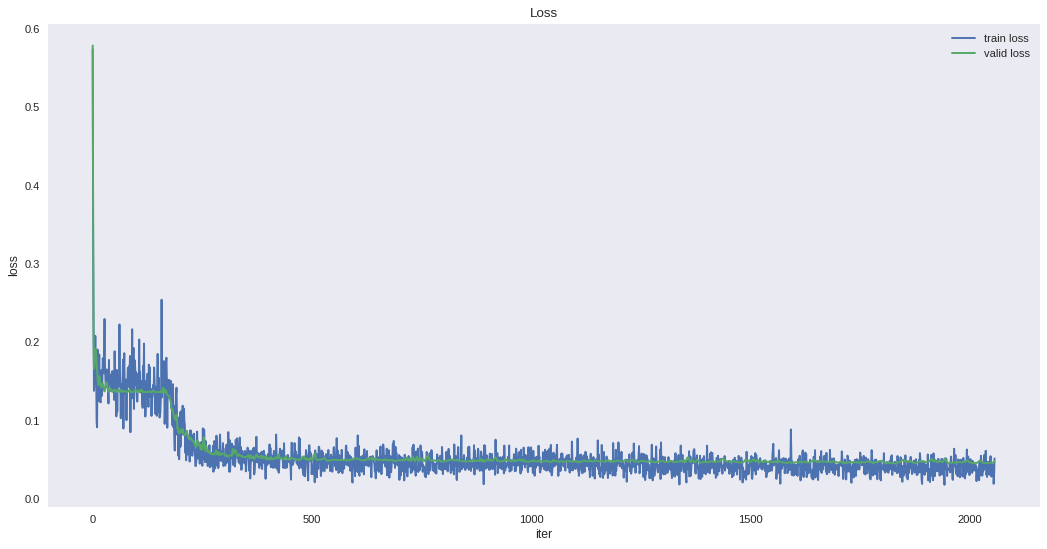

In [38]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

**Plot of ROC AUC vs iteration**

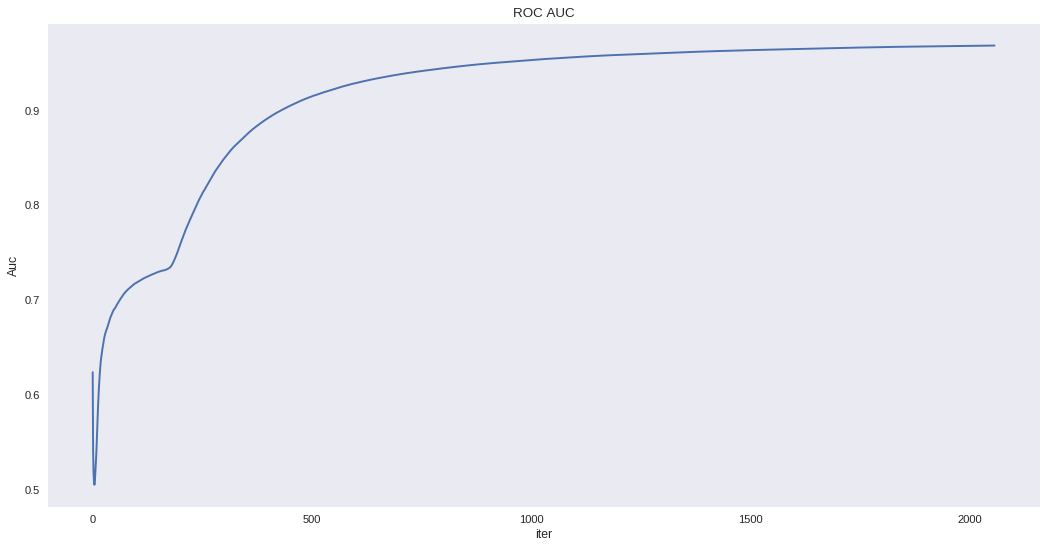

In [39]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_roc)
plt.title("ROC AUC")
plt.xlabel("iter")
plt.ylabel("Auc")
plt.grid()
plt.show()

# Create and Save submission file

In [0]:
del(comments_train, sentiments_train, seq_length_train, comments_validation, sentiments_validation, seq_length_validation)

**Create predictions matrix in folds and save the predictions in a csv file**

In [41]:
with tf.Session() as sess:  
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = len(test_id)
    k = 40
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        if i != (k-1):
            start = (step*i)
            end = (step*(i+1)) 
        else:
            start = (step*i)
            end = len(test_id)
            
        

        # feed dictionary for the fold
        feed_dict_test =  {X:sequence_generator(comments_test[start:end], max_length, size),
                            length:seq_length_test[start:end],
                            keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = logits.eval(session=sess, feed_dict = feed_dict_test)
        if i == 0:
            preds  = fold_preds
        else:
            preds = np.append(preds, fold_preds, axis=0)
        
        print("Computed predictions for fold",i)
        
    del(model, comments_test, seq_length_test)
    
    submission_matrix = np.append(np.transpose([test_id]), preds, axis=1)
    del(test_id)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    columns = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    submission = pd.DataFrame(submission_matrix, columns= columns)
    del(submission_matrix)
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-2055
Computed predictions for fold 0
Computed predictions for fold 1
Computed predictions for fold 2
Computed predictions for fold 3
Computed predictions for fold 4
Computed predictions for fold 5
Computed predictions for fold 6
Computed predictions for fold 7
Computed predictions for fold 8
Computed predictions for fold 9
Computed predictions for fold 10
Computed predictions for fold 11
Computed predictions for fold 12
Computed predictions for fold 13
Computed predictions for fold 14
Computed predictions for fold 15
Computed predictions for fold 16
Computed predictions for fold 17
Computed predictions for fold 18
Computed predictions for fold 19
Computed predictions for fold 20
Computed predictions for fold 21
Computed predictions for fold 22
Computed predictions for fold 23
Computed predictions for fold 24
Computed predictions for fold 25
Computed predictions for fold 26
Computed predictions for fold 27
Computed predictions for fol

**Save the submission file in google drive**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'submission.csv', 'parents':[{u'id': file_id_data["download_folder2_id"]}]})
uploaded.SetContentFile("submission.csv")
uploaded.Upload()